##Catboost on Image and Text Embeddings 


Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 52 kB/s 


In [2]:
#  Here we make all the imports required 
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tqdm.notebook import tqdm, trange
import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Importing all the Embeddings of Text and Images reducing them to 100 dim using PCA. 

In [5]:
concat_embeddings = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_embedding/ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [6]:
concat_embeddings_val = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_embedding/ConcatEmbeddings_dev_unseen.csv")
concat_embeddings_val.rename(columns={"0": "id"}, inplace=True)

In [7]:
concat_embeddings_test_unseen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_embedding/ConcatEmbeddings_test_unseen.csv")
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)
concat_embeddings_test_seen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_embedding/ConcatEmbeddings_test_seen.csv")
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

Importing all the JSON Files 

In [8]:
train_data = pd.read_json("/content/gdrive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
# batch_size = 32
# chunked_data = split_dataframe(train_data, batch_size)

(8500, 4)

In [9]:
val_data = pd.read_json("/content/gdrive/MyDrive/522-project/dev_unseen.jsonl", lines=True)
val_data.head()
val_data.shape

(540, 4)

In [10]:
test_unseen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_unseen.jsonl", lines=True)
test_unseen_data.head()
test_unseen_data.shape

(2000, 4)

In [11]:
test_seen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_seen.jsonl", lines=True)
test_seen_data.head()
test_seen_data.shape

(1000, 4)

In [12]:
train_embed = concat_embeddings[concat_embeddings.id.isin(train_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
target_train = train_data["label"].tolist()
print(len(train_embed))

8500


In [13]:
val_embed= concat_embeddings_val[concat_embeddings_val.id.isin(val_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
val_target = val_data["label"].tolist()
len(val_embed)

540

In [14]:
test_unseen_embed= concat_embeddings_test_unseen[concat_embeddings_test_unseen.id.isin(test_unseen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_unseen_target = test_unseen_data["label"].tolist()
len(test_unseen_embed)
len(test_unseen_target)

2000

In [15]:
test_seen_embed= concat_embeddings_test_seen[concat_embeddings_test_seen.id.isin(test_seen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_seen_target = test_seen_data["label"].tolist()
len(test_seen_embed)

1000

## Fitting the cocatenated Train embedding on the Catboost Model

We fine tuned the catboost model on various parameters such as :  

1. training iterations
2. regularization penalties of l2.
3. iterations
4. learning rate



In [16]:
train_embed = np.array(train_embed)
target_train = np.array(target_train)
val_embed = np.array(val_embed)
val_target = np.array(val_target)

In [17]:
import sklearn.metrics as metrics
clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.5, 
    loss_function='CrossEntropy',
    depth=3,
    l2_leaf_reg = 2,
    grow_policy= "Depthwise",
    random_strength = 0.1,
    od_type = 'IncToDec'  
)

clf.fit(train_embed, target_train)
# pred_y_cb_val = clf.predict(val_embed)
# pred_y_cb_train =  clf.predict(train_embed)

0:	learn: 0.6225812	total: 524ms	remaining: 51.9s
1:	learn: 0.5943099	total: 999ms	remaining: 48.9s
2:	learn: 0.5778806	total: 1.46s	remaining: 47.1s
3:	learn: 0.5638602	total: 1.93s	remaining: 46.3s
4:	learn: 0.5533532	total: 2.38s	remaining: 45.2s
5:	learn: 0.5435460	total: 2.85s	remaining: 44.6s
6:	learn: 0.5330030	total: 3.3s	remaining: 43.9s
7:	learn: 0.5243269	total: 3.76s	remaining: 43.3s
8:	learn: 0.5155732	total: 4.22s	remaining: 42.7s
9:	learn: 0.5078144	total: 4.68s	remaining: 42.1s
10:	learn: 0.4988718	total: 5.13s	remaining: 41.5s
11:	learn: 0.4917197	total: 5.57s	remaining: 40.9s
12:	learn: 0.4853112	total: 6.04s	remaining: 40.4s
13:	learn: 0.4791147	total: 6.48s	remaining: 39.8s
14:	learn: 0.4721530	total: 6.96s	remaining: 39.4s
15:	learn: 0.4664214	total: 7.38s	remaining: 38.8s
16:	learn: 0.4597532	total: 7.83s	remaining: 38.2s
17:	learn: 0.4547436	total: 8.28s	remaining: 37.7s
18:	learn: 0.4480990	total: 8.73s	remaining: 37.2s
19:	learn: 0.4427231	total: 9.16s	remainin

## Testing on the Validation Set

AUC0.5746176470588236


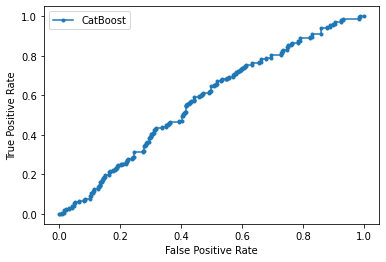

precision :0.4166666666666667 recall :0.25 f1 :0.3125 accuracy :0.5925925925925926


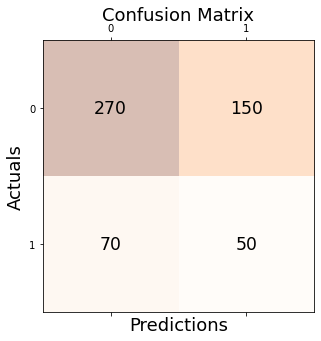

Precision vs Recall


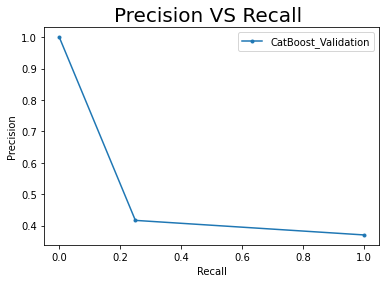

In [18]:
preds = clf.predict(val_embed)
lr_probs = clf.predict_proba(val_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(val_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_target, lr_probs)
print("AUC" + str(lr_auc))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(val_target, preds, average='binary')
acc = accuracy_score(val_target, preds)
r = confusion_matrix(preds, val_target)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(val_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Validation')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

## Testing on Test Seen Data

AUC0.6238695478191276


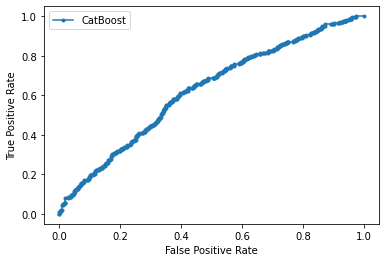

precision :0.5933333333333334 recall :0.363265306122449 f1 :0.45063291139240513 accuracy :0.566


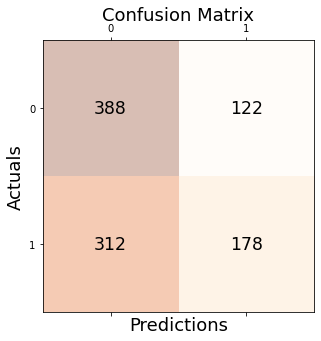

Precision vs Recall


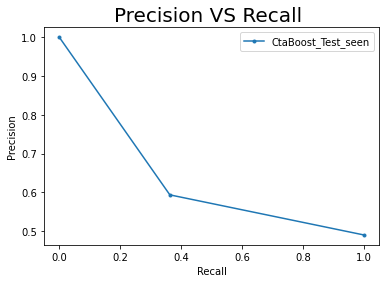

In [19]:
preds = clf.predict(test_seen_embed)
lr_probs = clf.predict_proba(test_seen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_seen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_seen_target, lr_probs)
print("AUC" + str(lr_auc))

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_seen_target, preds, average='binary')
acc = accuracy_score(test_seen_target, preds)

r = confusion_matrix(test_seen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(test_seen_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CtaBoost_Test_seen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

## Testing on the unseen test data

AUC0.6127082666666667


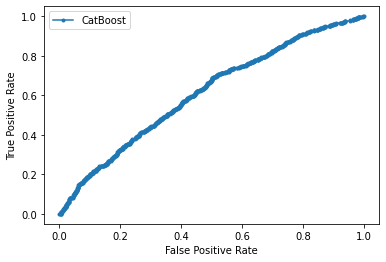

precision :0.4835766423357664 recall :0.35333333333333333 f1 :0.40832049306625573 accuracy :0.616


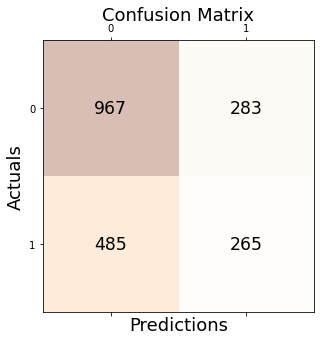

Precision vs Recall


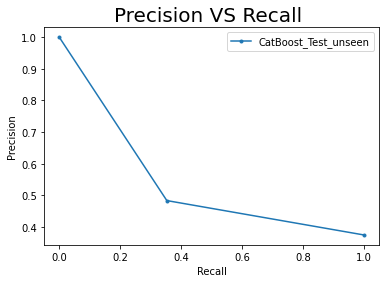

In [20]:
preds = clf.predict(test_unseen_embed)
lr_probs = clf.predict_proba(test_unseen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_unseen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_unseen_target, lr_probs)
print("AUC" + str(lr_auc))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_unseen_target, preds, average='binary')
acc = accuracy_score(test_unseen_target, preds)
r = confusion_matrix(test_unseen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision1, recall1, thresholds = precision_recall_curve(test_unseen_target, preds)
print("Precision vs Recall")
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Test_unseen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()